In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pickle


In [3]:
data = pd.read_csv(r"E:\Datasets\Crop_Recommendation.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


In [6]:
data.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [7]:
print("Missing values per column:")
data.isnull().sum()

Missing values per column:


Nitrogen       0
Phosphorus     0
Potassium      0
Temperature    0
Humidity       0
pH_Value       0
Rainfall       0
Crop           0
dtype: int64

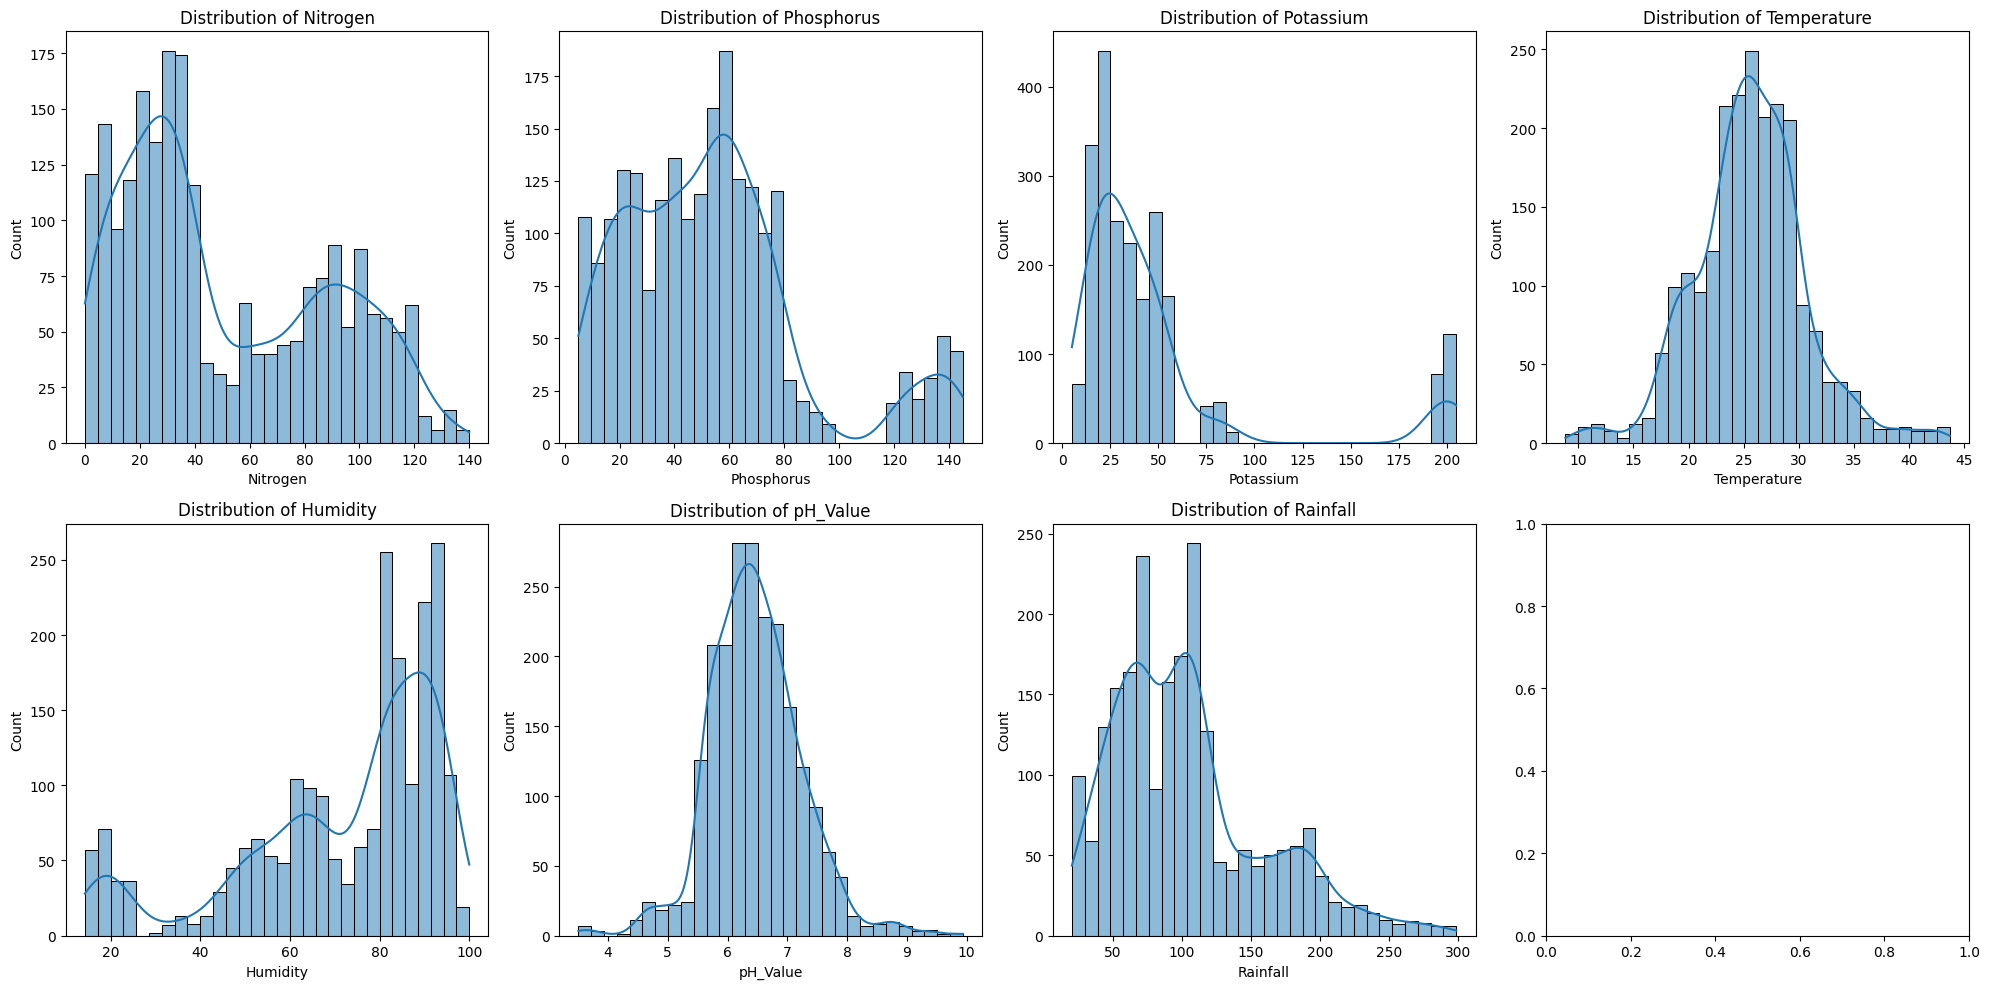

In [8]:
# Distribution of continuous features
features = ["Nitrogen", "Phosphorus", "Potassium", "Temperature", "Humidity", "pH_Value", "Rainfall"]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, feature in enumerate(features):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

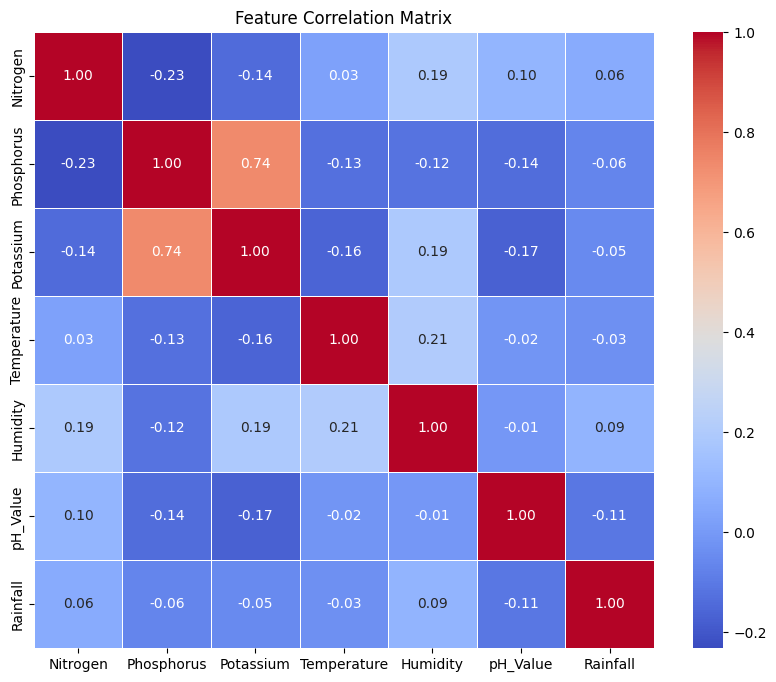

In [9]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(columns=["Crop"]).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
data["Crop"].value_counts()

Crop
Rice           100
Maize          100
Jute           100
Cotton         100
Coconut        100
Papaya         100
Orange         100
Apple          100
Muskmelon      100
Watermelon     100
Grapes         100
Mango          100
Banana         100
Pomegranate    100
Lentil         100
Blackgram      100
MungBean       100
MothBeans      100
PigeonPeas     100
KidneyBeans    100
ChickPea       100
Coffee         100
Name: count, dtype: int64

In [13]:
crop_dict = {
    'Rice': 1, 'Maize': 2, 'Jute': 3, 'Cotton': 4, 'Coconut': 5, 'Papaya': 6, 'Orange': 7, 'Apple': 8,
    'Muskmelon': 9, 'Watermelon': 10, 'Grapes': 11, 'Mango': 12, 'Banana': 13, 'Pomegranate': 14,
    'Lentil': 15, 'Blackgram': 16, 'MungBean': 17, 'MothBeans': 18, 'PigeonPeas': 19, 'KidneyBeans': 20,
    'ChickPea': 21, 'Coffee': 22
}
data['crop_num'] = data['Crop'].map(crop_dict)

In [14]:
# Splitting data into features (X) and target (y)
X = data.drop(['Crop', 'crop_num'], axis=1)
y = data['crop_num'] - 1  # Adjusting for zero-indexed target


In [15]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
# Save scaler for later use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [20]:
# Dictionary to hold best models and their scores
results = {}

In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 200]
}
log_reg = LogisticRegression()
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=kf, n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

# Evaluate Logistic Regression on the test set
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Calculate k-fold cross-validation accuracy
k_fold_accuracies = cross_val_score(best_lr, X_train_scaled, y_train, cv=kf, scoring='accuracy')
mean_k_fold_accuracy = np.mean(k_fold_accuracies)

# Store results and print accuracy metrics
results['Logistic Regression'] = (best_lr, test_accuracy_lr)
print(f"Logistic Regression Test Accuracy: {test_accuracy_lr:.4f}")
print(f"Logistic Regression K-Fold Cross-Validation Accuracy: {mean_k_fold_accuracy:.4f}")


Logistic Regression Test Accuracy: 0.9614
Logistic Regression K-Fold Cross-Validation Accuracy: 0.9727


c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# model for logistic regression
with open('best_lr.pkl', 'wb') as f:
    pickle.dump(best_lr, f)

In [25]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rfc = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rfc, param_grid_rf, cv=kf, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

# Evaluate Random Forest on the test set
best_rfc = grid_search_rf.best_estimator_
y_pred_rf = best_rfc.predict(X_test_scaled)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate k-fold cross-validation accuracy
k_fold_accuracies_rf = cross_val_score(best_rfc, X_train_scaled, y_train, cv=kf, scoring='accuracy')
mean_k_fold_accuracy_rf = np.mean(k_fold_accuracies_rf)

# Store results and print accuracy metrics
results['Random Forest'] = (best_rfc, test_accuracy_rf)
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Random Forest K-Fold Cross-Validation Accuracy: {mean_k_fold_accuracy_rf:.4f}")


Random Forest Test Accuracy: 0.9932
Random Forest K-Fold Cross-Validation Accuracy: 0.9960


In [26]:
#random forest model
with open('best_rfc.pkl', 'wb') as f:
    pickle.dump(best_rfc, f)

In [27]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'subsample': [0.6, 0.8]
}
xgb_classifier = XGBClassifier(eval_metric='mlogloss')
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=kf, n_jobs=-1)
grid_search_xgb.fit(X_train_scaled, y_train)

# Evaluate XGBoost on the test set
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Calculate k-fold cross-validation accuracy
k_fold_accuracies_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=kf, scoring='accuracy')
mean_k_fold_accuracy_xgb = np.mean(k_fold_accuracies_xgb)

# Store results and print accuracy metrics
results['XGBoost'] = (best_xgb, test_accuracy_xgb)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"XGBoost K-Fold Cross-Validation Accuracy: {mean_k_fold_accuracy_xgb:.4f}")


c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\acer\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 151

XGBoost Test Accuracy: 0.9864
XGBoost K-Fold Cross-Validation Accuracy: 0.9898


In [28]:
# best xgb
with open('best_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

In [29]:
# Summary of results
print("\nModel Performance Summary:")
for model_name, (model, accuracy) in results.items():
    print(f"{model_name}: {accuracy:.4f}")


Model Performance Summary:
Logistic Regression: 0.9614
Random Forest: 0.9932
XGBoost: 0.9864
